##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 컨볼루셔널 변이형 오토인코더

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cvae"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.org에서보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/cvae.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/cvae.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/generative/cvae.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

이 노트북은 MNIST 데이터세트에서 변이형 오토인코더(VAE, Variational Autoencoder)를 훈련하는 방법을 보여줍니다([1](https://arxiv.org/abs/1312.6114) , [2](https://arxiv.org/abs/1401.4082)). VAE는 오토인코더의 확률론적 형태로, 높은 차원의 입력 데이터를 더 작은 표현으로 압축하는 모델입니다. 입력을 잠재 벡터에 매핑하는 기존의 오토인코더와 달리 VAE는 입력 데이터를 가우스 평균 및 분산과 같은 확률 분포의 매개변수에 매핑합니다. 이 방식은 연속적이고 구조화된 잠재 공간을 생성하므로 이미지 생성에 유용합니다.

![CVAE 이미지 잠재 공간](images/cvae_latent_space.jpg)

## 설정

In [2]:
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Using cached tensorflow_probability-0.19.0-py2.py3-none-any.whl (6.7 MB)


  Using cached dm_tree-0.1.7-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (142 kB)


  Using cached cloudpickle-2.2.0-py3-none-any.whl (25 kB)


  Cloning https://github.com/tensorflow/docs to /tmpfs/tmp/pip-req-build-dy7ua2vi


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmpfs/tmp/pip-req-build-dy7ua2vi


  Resolved https://github.com/tensorflow/docs to commit 7ec3498211be67edf739754575ee4745c05b95ef


  Preparing metadata (setup.py) ... -

 done


  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)


 \

 done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180390 sha256=602503718d215d6e6392770ca4d9f0e3d1c70ec5929c9a714c95589f2540a4c7
  Stored in directory: /tmpfs/tmp/pip-ephem-wheel-cache-wlvfji2f/wheels/fc/f8/3b/5d21409a59cb1be9b1ade11f682039ced75b84de9dd6a0c8de
Successfully built tensorflow-docs


In [3]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

2022-12-14 23:28:34.955323: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 23:28:34.955418: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 23:28:34.955428: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## MNIST 데이터세트 로드하기

각 MNIST 이미지는 원래 각각 0-255 사이인 784개의 정수로 구성된 벡터이며 픽셀 강도를 나타냅니다. 모델에서 Bernoulli 분포를 사용하여 각 픽셀을 모델링하고 데이터세트를 정적으로 이진화합니다.

In [4]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [5]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [6]:
train_size = 60000
batch_size = 32
test_size = 10000

## *tf.data*를 사용하여 데이터 배치 및 셔플 처리하기

In [7]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

## *tf.keras.Sequential*을 사용하여 인코더 및 디코더 네트워크 정의하기

이 VAE 예제에서는 인코더 및 디코더 네트워크에 두 개의 작은 ConvNet을 사용합니다. 문헌에서, 이들 네트워크는 각각 추론/인식 및 생성 모델로도 지칭됩니다. 구현을 단순화하기 위해 `tf.keras.Sequential`을 사용합니다. 다음 설명에서 $x$ 및 $z$는 각각 관측 값과 잠재 변수를 나타냅니다.

### 인코더 네트워크

이것은 근사 사후 분포 $q(z|x)$를 정의합니다. 이 분포는 관측 값을 입력으로 받고 잠재 표현 $z$의 조건부 분포를 지정하기 위한 매개변수 세트를 출력합니다. 이 예에서는 분포를 대각선 가우스로 간단히 모델링하고 네트워크는 인수 분해된 가우스의 평균 및 로그-분산 매개변수를 출력합니다. 수치 안정성을 위해 분산을 직접 출력하지 않고 로그-분산을 출력합니다.

### 디코더 네트워크

잠재 샘플 $z$를 입력으로 사용하여 관측 값의 조건부 분포에 대한 매개변수를 출력하는 관측 값 $p(x|z)$의 조건부 분포를 정의합니다. 잠재 이전 분포 $p(z)$를 단위 가우스로 모델링합니다.

### 재매개변수화 트릭

훈련 중에 디코더에 대해 샘플 $z$를 생성하기 위해, 입력 관측 값 $x$가 주어졌을 때 인코더에 의해 출력된 매개변수로 정의된 잠재 분포로부터 샘플링할 수 있습니다. 그러나 역전파가 무작위 노드를 통해 흐를 수 없기 때문에 이 샘플링 작업에서 병목 현상이 발생합니다.

이를 해결하기 위해 재매개변수화 트릭을 사용합니다. 이 예에서는 디코더 매개변수와 다른 매개변수 $\epsilon$을 다음과 같이 사용하여 $z$를 근사시킵니다.

$$z = \mu + \sigma \odot \epsilon$$

여기서 $\mu$ 및 $\sigma$는 각각 가우스 분포의 평균 및 표준 편차를 나타냅니다. 이들은 디코더 출력에서 파생될 수 있습니다. $\epsilon$은 $z$의 무질서도를 유지하는 데 사용되는 무작위 노이즈로 생각할 수 있습니다. 표준 정규 분포에서 $\epsilon$을 생성합니다.

잠재 변수 $z$는 이제 $\mu$, $\sigma$ 및 $\epsilon$의 함수에 의해 생성되며, 이를 통해 모델은 각각 $\mu$ 및 $\sigma$를 통해 인코더의 그래디언트를 역전파하면서 $epsepson$를 통해 무질서도를 유지할 수 있습니다.

### 네트워크 아키텍처

인코더 네트워크의 경우 두 개의 컨볼루션 레이어, 그리고 이어서 완전히 연결된 레이어를 사용합니다. 디코더 네트워크에서 완전히 연결된 레이어와 그 뒤에 세 개의 컨볼루션 전치 레이어(일부 컨텍스트에서는 디컨볼루션 레이어라고도 함)를 사용하여 이 아키텍처를 미러링합니다. 미니 배치 사용으로 인한 추가 무질서도가 샘플링의 무질서에 더해 불안정성을 높일 수 있으므로 VAE 훈련시 배치 정규화를 사용하지 않는 것이 일반적입니다.


In [8]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

## 손실 함수 및 옵티마이저 정의하기

VAE는 한계 로그-우도에 대한 ELBO(evidence lower bound)를 최대화하여 훈련합니다.

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

실제로, 이 예상에 대한 단일 샘플 Monte Carlo 추정값을 최적화합니다.

$$\log p(x| z) + \log p(z) - \log q(z|x),$$ 여기서 $z$는 $q(z|x)$에서 샘플링됩니다.

참고: KL 항을 분석적으로 계산할 수도 있지만 여기서는 단순화를 위해 Monte Carlo 예측 도구에 세 항을 모두 통합합니다.

In [9]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## 훈련하기

- 데이터세트를 반복하여 시작합니다.
- 반복하는 동안 매번 이미지를 인코더로 전달하여 근사적인 사후 $q(z|x)$의 평균 및 로그-분산 매개변수 세트를 얻습니다.
- 그런 다음 $q(z|x)$에서 샘플링하기 위해 *재매개변수화 트릭*을 적용합니다.
- 마지막으로, 생성된 분포 $p(x|z)$의 로짓을 얻기 위해 재매개변수화된 샘플을 디코더로 전달합니다.
- 참고: 훈련 세트에 60k 데이터 포인트와 테스트 세트에 10k 데이터 포인트가 있는 keras에 의해 로드된 데이터세트를 사용하기 때문에 테스트세트에 대한 결과 ELBO는 Larochelle MNIST의 동적 이진화를 사용하는 문헌에서 보고된 결과보다 약간 높습니다.

### 이미지 생성하기

- 훈련을 마쳤으면 이미지를 생성할 차례입니다.
- 우선, 단위 가우스 사전 분포 $p(z)$에서 잠재 벡터 세트를 샘플링합니다.
- 그러면 생성기가 잠재 샘플 $z$를 관측 값의 로짓으로 변환하여 분포 $p(x|z)$를 제공합니다.
- 여기서 Bernoulli 분포의 확률을 플롯합니다.


In [10]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [11]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [12]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -157.08872985839844, time elapse for current epoch: 6.16221022605896


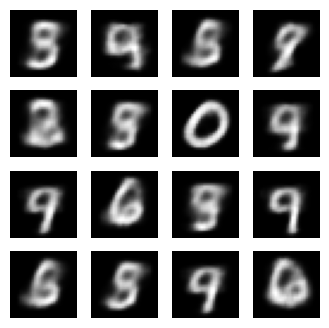

In [13]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

### 마지막 훈련 epoch에서 생성된 이미지 표시하기

In [14]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

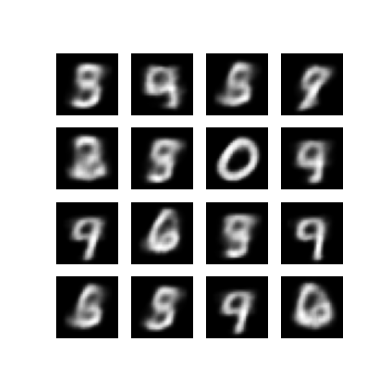

In [15]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

### 저장된 모든 이미지의 애니메이션 GIF 표시하기

In [16]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/tmpfs/tmp/ipykernel_783731/1290275450.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


/tmpfs/tmp/ipykernel_783731/1290275450.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



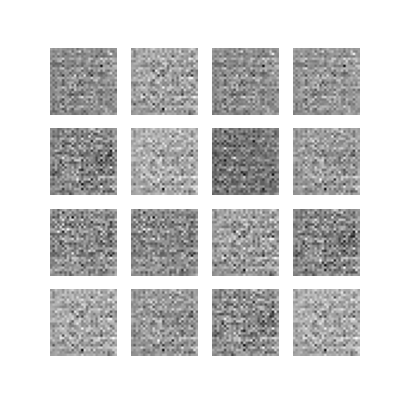

In [17]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### 잠재 공간에서 숫자의 2D 형태 표시하기

아래 코드를 실행하면 다른 숫자 클래스의 연속 분포가 표시되며 각 숫자는 2D 잠재 공간에서 다른 숫자로 모핑됩니다. 여기서는 잠재 공간에 대한 표준 정규 분포를 생성하기 위해 [TensorFlow Probability](https://www.tensorflow.org/probability)를 사용합니다.

In [18]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

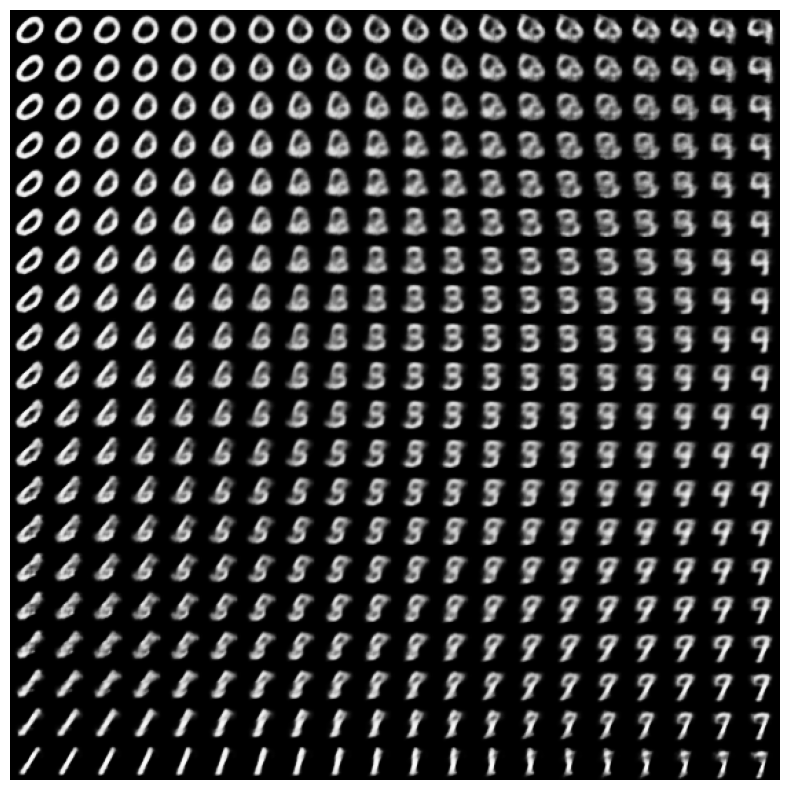

In [19]:
plot_latent_images(model, 20)

## 다음 단계

이 튜토리얼에서는 TensorFlow를 사용하여 컨볼루셔널 변이형 오토인코더를 구현하는 방법을 설명했습니다.

다음 단계로 네트워크 크기를 증가시켜 모델 출력의 개선을 시도할 수 있습니다. 예를 들어, 각 `Conv2D` 및`Conv2DTranspose` 레이어에 대한 `filter` 매개변수를 512로 설정할 수 있습니다. 최종 2D 잠재 이미지 플롯을 생성하기 위해 `latent_dim`을 2로 유지해야 합니다. 또한, 네트워크 크기가 증가할수록 훈련 시간이 늘어납니다.

CIFAR-10과 같은 다른 데이터세트를 사용하여 VAE를 구현할 수도 있습니다.

VAE는 여러 가지 스타일과 다양한 복잡도로 구현할 수 있습니다. 다음 자료에서 추가 구현을 찾을 수 있습니다.

- [변이형 오토인코더(keras.io)](https://keras.io/examples/generative/vae/)
- ["사용자 정의 레이어 및 모델 작성" 가이드의 VAE 예제(tensorflow.org)](https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example)
- [TFP 확률 레이어: 변이형 오토인코더](https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE)

VAE에 대한 자세한 내용을 알아보려면 [변이형 오토인코더 소개](https://arxiv.org/abs/1906.02691)를 참조하세요.